<a href="https://colab.research.google.com/github/sjkim-audio/guitar-bass-separator/blob/main/notebooks/Exp004_OpenUnmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 공유 드라이브에 있는 오디오 파일 다운로드

import gdown
import librosa
from IPython.display import Audio

# 1. 구글 드라이브 공유 링크에서 'FILE_ID' 부분만 추출
# 예: https://drive.google.com/file/d/1A2B3C.../view -> '1A2B3C...'
file_id = '1bjwVU8lThj2E1TDs1rwhZwZTcUgTOASc'

# 2. 다운로드할 URL 구성 & 파일 저장 경로 설정 & 다운로드
url = f'https://drive.google.com/uc?id={file_id}'
output_filename = 'downloaded_audio.wav'
gdown.download(url, output_filename, quiet=False)

# 3. 다운로드한 파일 로드 (48kHz 설정)
# y: 오디오 데이터, sr: 샘플링 레이트 (해당 음원은 48kHz로 렌더링됨)
try:
    y, sr = librosa.load(output_filename, sr=None)
    print(f"샘플링 레이트 {sr}Hz")
    print(f"오디오 길이: {len(y) / sr:.2f}초")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")

Audio(data=y, rate=sr)

In [ ]:
# 1. 라이브러리 설치
# OpenUnmix는 PyTorch 기반의 공식 라이브러리를 제공합니다.
!pip install openunmix torch torchaudio

import torch
import torchaudio
import openunmix.utils

# 2. 오디오 파일 불러오기 및 전처리
# Numpy 배열을 PyTorch 텐서로 변환
# 차원 확인 및 조정
input_audio = torch.tensor(y)
if input_audio.dim() == 1:
    input_audio = input_audio.unsqueeze(0)

# 48kHz인 경우 모델에 맞게 리샘플링이 필요함. (UMX 기본은 44.1kHz)
sr = 44100

# 3. 모델 로드 (umxhq: 고음질 선학습 모델)
# 인터넷에서 학습된 가중치(Weight) 다운로드
print("모델 로드 중...")
separator = torch.hub.load('sigsep/open-unmix-pytorch', 'umxhq', device='cuda' if torch.cuda.is_available() else 'cpu')

print(f"텐서 크기: {input_audio.shape}")
print("모델 다운 완료")

# estimates 결과는 딕셔너리 형태. {'bass': ..., 'drums': ..., 'vocals': ..., 'other': ...}
# 보컬, 드럼, 베이스과 나머지(other)로 구분하기 때문에 기타(Guitar)는 보통 'other'에 포함


In [ ]:
# 1. 현재 오디오 모양 확인
print(f"원본 텐서 모양: {input_audio.shape}")

# 2. 차원 검사 및 수정 (가장 중요한 부분!)
# Case A: 데이터가 1차원인 경우 [Time] -> [1, Time] (채널 차원 추가)
if input_audio.dim() == 1:
    input_audio = input_audio.unsqueeze(0)

# Case B: 모노(1채널)인 경우 -> 스테레오(2채널)로 복사
# UMX는 무조건 스테레오 입력을 요구함
if input_audio.shape[0] == 1:
    print("⚠️ 모노(1ch) 신호를 강제로 스테레오(2ch)로 변환합니다.")
    input_audio = input_audio.repeat(2, 1)

# 3. 배치 차원 추가 (Batch Dimension)
# [Channels, Time] -> [1, Channels, Time]
input_tensor = input_audio.unsqueeze(0)

# 4. 장치(GPU/CPU) 설정 및 이동
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"사용 장치: {device}")

# 모델과 데이터를 같은 장치로 이동
separator = separator.to(device)
input_tensor = input_tensor.to(device)

print(f"최종 입력 텐서 모양: {input_tensor.shape}")
# 정상 출력 예시: torch.Size([1, 2, 264000])

# 5. 분리 수행
with torch.no_grad(): # 평가 모드
    estimates = separator(input_tensor)

print("✅ 분리 완료!")

In [ ]:
import numpy as np
from IPython.display import Audio, display

# 1. 텐서를 CPU로 가져오고 Numpy 배열로 변환
# estimates 형태: [1, 4, 2, Time] (Batch, Sources, Channels, Time)
# 모델이 GPU에서 돌았을 수 있으므로 .detach().cpu()가 필수입니다.
estimates_numpy = estimates.detach().cpu().numpy()[0]

# 2. 소스 이름 매핑
# OpenUnmix의 기본 출력 순서는 ['bass', 'drums', 'other', 'vocals'] 입니다.
source_names = ['bass', 'drums', 'other', 'vocals']
audios = dict(zip(source_names, estimates_numpy))

# 3. 베이스와 기타(Other) 트랙 추출
bass_audio = audios['bass']
guitar_audio = audios['other'] # 기타는 'other'에 포함됨

# 4. 결과 청취
# sr은 이전 단계에서 로드할 때 사용한 샘플링 레이트 변수입니다. (보통 44100 or 48000)
print("🎧 Original Input Check:")
# 원본 비교를 위해 입력 오디오도 들어보는 것을 추천 (선택)
# display(Audio(input_audio.cpu().numpy()[0], rate=sr))

print("-" * 30)
print("🎸 OpenUnmix Extracted Bass:")
display(Audio(bass_audio, rate=sr))

print("🎸 OpenUnmix Extracted Guitar (Other):")
display(Audio(guitar_audio, rate=sr))

1차 실험

베이스 트랙과 기타 트랙이 바뀌어 출력된 듯 함

In [ ]:
# ... (이전 코드 동일)

# 2. 소스 이름 매핑 (여기서 강제로 스왑)
# 현상: 베이스 트랙에서 기타 소리가 나고, Other 트랙에서 베이스 소리가 남
# 조치: 변수를 서로 바꿔서 할당
# 청감 테스트를 통해 라벨링을 수동으로 교정(Swapping)하여 해결.

real_bass_audio = audios['other']  # AI가 'Other'라고 착각한 것이 진짜 베이스
real_guitar_audio = audios['bass'] # AI가 'Bass'라고 착각한 것이 진짜 기타

print("🔄 교차 검증 완료: AI 분류 오류 수정됨 (Bass <-> Other)")

print("-" * 30)
print("🎸 Real Bass (From 'Other' channel):")
display(Audio(real_bass_audio, rate=sr))

print("🎸 Real Guitar (From 'Bass' channel):")
display(Audio(real_guitar_audio, rate=sr))

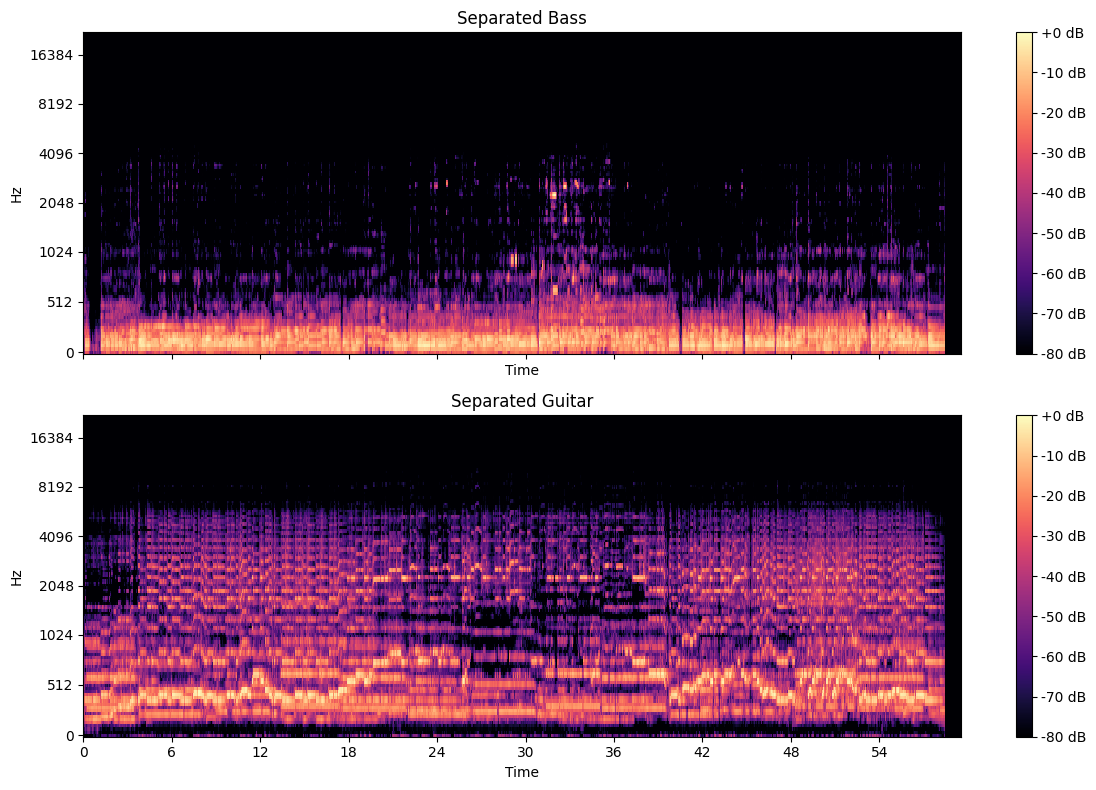

In [12]:
import matplotlib.pyplot as plt

# 분리된 트랙 시각화
# 시각화를 위한 함수 정의
def plot_mel_spectrogram(y, sr, title, ax):
    # 0. 신호가 스테레오라면 모노로 합침
    if y.ndim > 1:
        y = np.mean(y, axis=0)

    # 1. 멜 스펙트로그램 계산
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # 2. dB로 변환
    S_dB = librosa.power_to_db(S, ref=np.max)

    # 3. 그리기
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(title)
    return img

# 그래프 그리기 설정 (2행 1열)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1. 베이스 트랙 시각화
img1 = plot_mel_spectrogram(real_bass_audio, sr, 'Separated Bass', axes[0])
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

# 2. 기타 트랙 시각화
img2 = plot_mel_spectrogram(real_guitar_audio, sr, 'Separated Guitar', axes[1])
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()